**Montando o Google** **Drive**


In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Mounted at /content/drive


**Importando as bibliotecas**

In [ ]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim
# import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils




**Opções para reprodutibilidade**

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

**Verificando acesso á GPU**

In [ ]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cpu


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


**O Dataset**

In [ ]:
if IN_COLAB:
  train_path ='/content/drive/MyDrive/experimentos/Nuts/Nuts/train'
  test_path ='/content/drive/MyDrive/experimentos/Nuts/Nuts/test'
  val_path = '/content/drive/MyDrive/experimentos/Nuts/Nuts/val'


EXP_PATH = '/content/drive/MyDrive/experimentos/alexnet'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

In [ ]:
#Apenas as pastas estãos sendo listadas ## ok
class_names = os.listdir(val_path)

#num classes

num_classes  = len(class_names)

In [ ]:
print(class_names)
print(num_classes)

['Almond', 'Brazil Nut', 'Cashew', 'Chestnut', 'Hazelnut', 'Macadamia', 'Peanut', 'Pecan', 'Pine Nut', 'Pistachio', 'Walnut']
11


**Setando alguns Parâmetros**

In [ ]:
#Tamanho dos lotes (mini-batch)
batch_size = 64

#taxa de aprendizado (learn reating)

lr = 0.001

#mommentum

mm = 0.9

#num epocas
epochs = 30

#step size
ss = 10

In [ ]:
ARCH_NAME = 'alexnet' #'simplenet','alexnet','resnet18'...

**Preparando o dataset**

---



In [ ]:
#treinamento
data_transforms = transforms.Compose([##vou redimensionar pra 299 por causa
                                      ##do inceptionV3
                                      transforms.Resize(size=(224,224)),
                                      transforms.ToTensor(),
                                      #normalização da imagem. Média e desvio padrao da imagenet.
                                      #modelo pretreinado com o imagenet.
                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                      ])

#imagefolder: constroi um dataset a partir de uma pasta
train_dataset = datasets.ImageFolder(train_path,transform=data_transforms)
val_dataset =  datasets.ImageFolder(val_path,transform=data_transforms)
test_dataset = datasets.ImageFolder(test_path,transform=data_transforms)

**Definindo o conjunto de treino**

In [ ]:
#nosso dataset ja esta separado

train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

print(train_size)
print(val_size)
print(test_size)

1320
440
440


In [ ]:
#defnindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset= train_dataset,batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset= val_dataset,batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset= test_dataset,batch_size=batch_size)

**Visualizando as imagens**

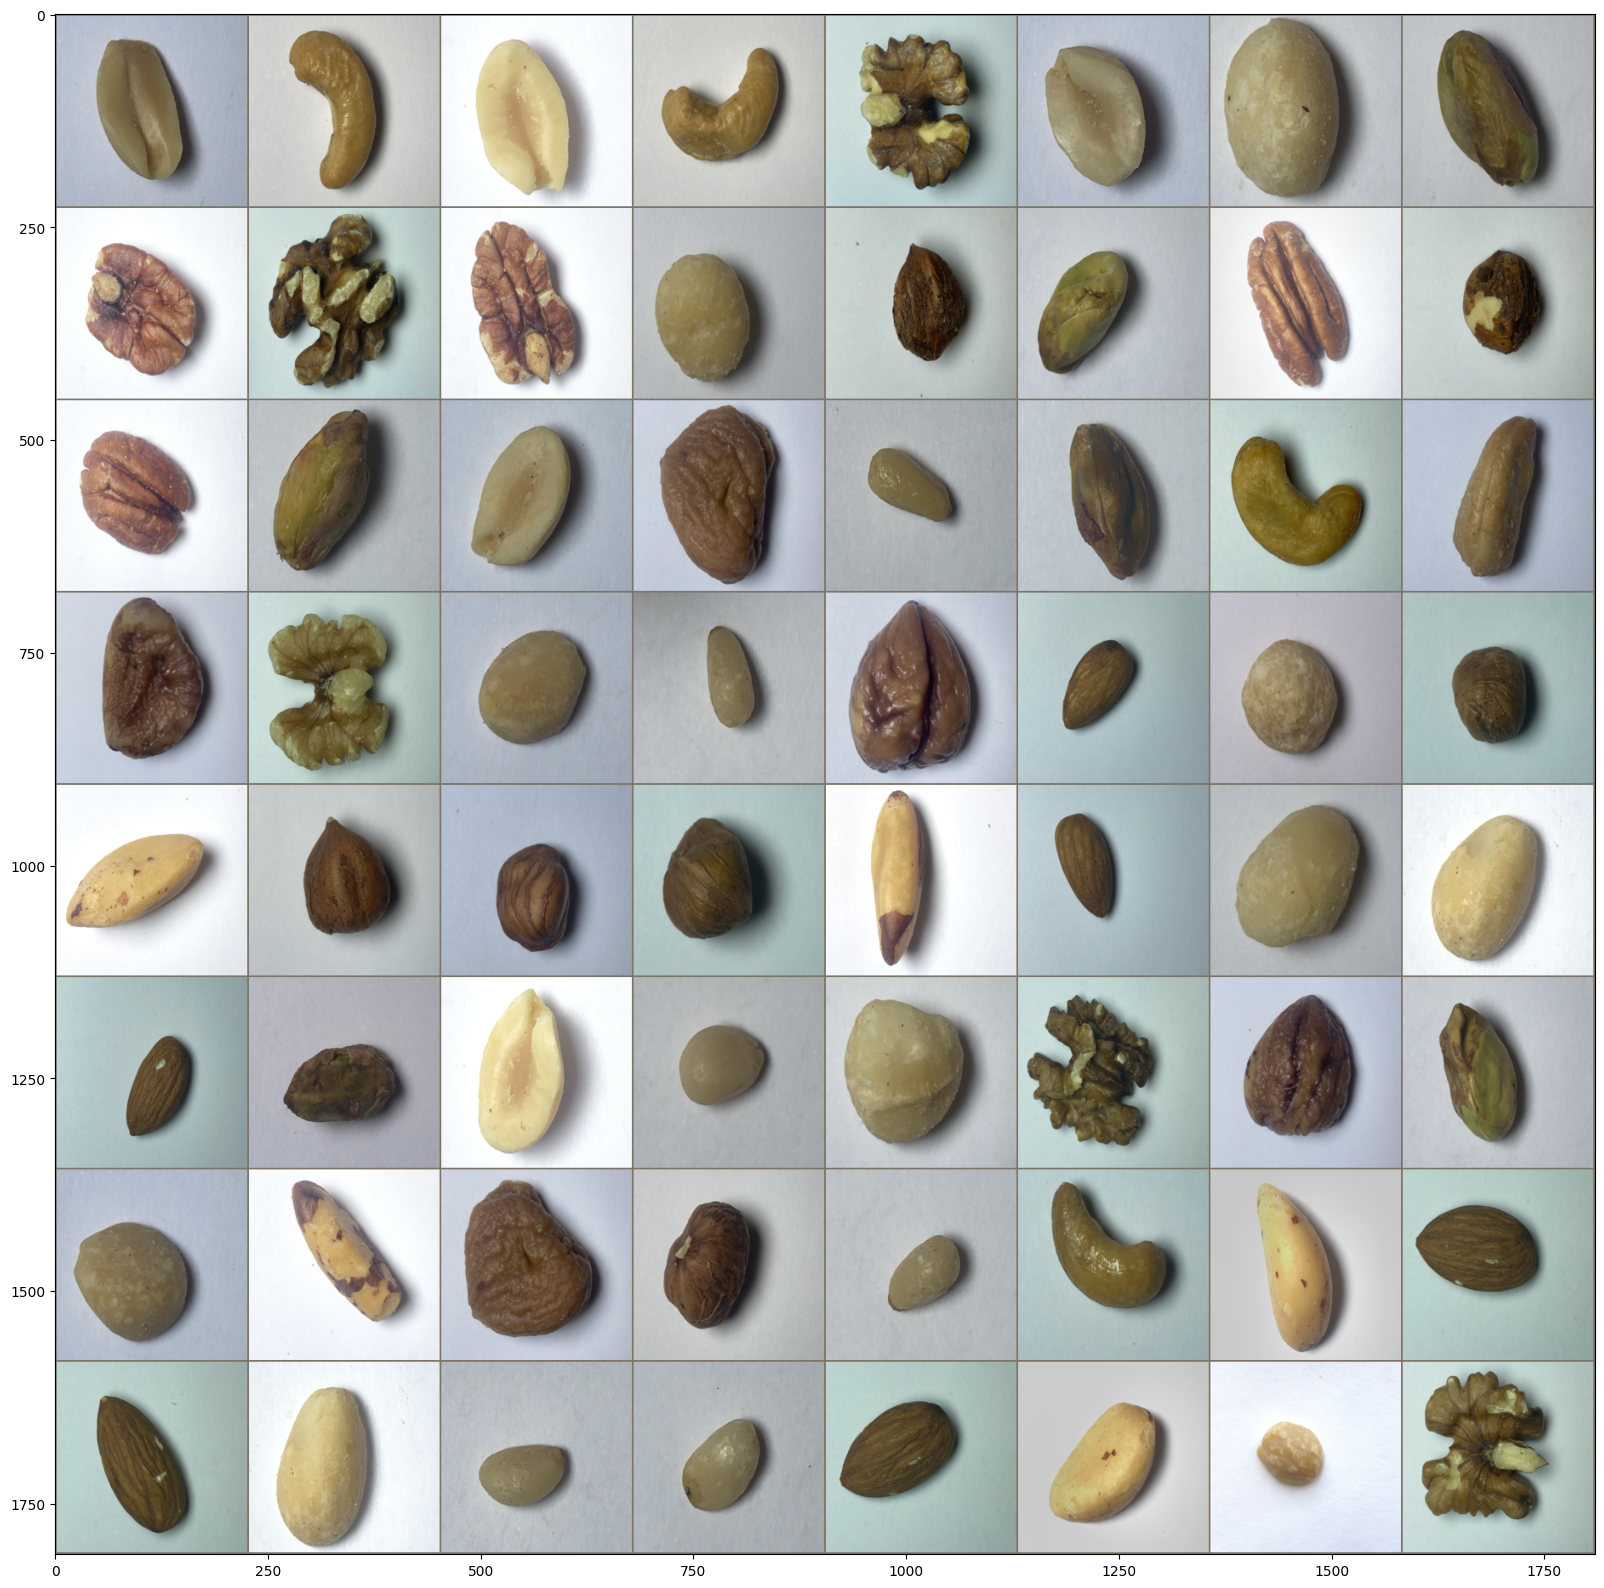

In [ ]:
def show_transformed_image(image):
    # Unnormalize the channels. ImageNet weights
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)

    # From tensor to numpy array
    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label ,*_ = next(items)

show_transformed_image(utils.make_grid(image))

plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf'))

**Selecionando o modelo**

In [ ]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(224, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.classifier[6].in_features
    ### model.classifier[6] = nn.Linear(4096, num_classes)
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    ### model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'inceptionV3':
    # Carrega o modelo InceptionV3 (sem pesos pré-treinados no ImageNet)
    model = models.inception_v3()

    # Altera a camada de saída para se adequar ao seu problema
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)


    # Include more architectures...
    ### elif ARCH_NAME == ...

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 180MB/s]


In [ ]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Imprime o modelo
print(str(model))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Função de perda e otimizador**

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

# Adjust learning rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

**Treinando o modelo**

In [ ]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

# Learning rate list
lr_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0.0
    # Amostras classificadas corretamente nesta época
    hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels, *_ in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model(inputs)

        #  Tomar o maior valor de 'outputs' como predição.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model.eval()

    # Epoch validation loss
    loss_epoch_val = 0.0 #
    # Num hits for this epoch
    hits_epoch_val = 0

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels, *_ in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False)

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model(inputs)

        # Retorna o maior valor como predição.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Atualiza os acertos da época
        hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    scheduler.step()

    # Store the learning rate
    lr_epoch = optimizer.param_groups[0]['lr']
    lr_list.append(lr_epoch)

    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print(f'Epoch {epoch}/{ epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTreinamento finalizado. ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

Epoch 0/29 - TRAIN Loss: 2.9417 TRAIN Acc: 0.0909 - VAL. Loss: 2.3439 VAL. Acc: 0.1727 (890.4268 seconds)
Epoch 1/29 - TRAIN Loss: 2.4091 TRAIN Acc: 0.0758 - VAL. Loss: 2.3146 VAL. Acc: 0.1682 (261.6653 seconds)
Epoch 2/29 - TRAIN Loss: 2.5418 TRAIN Acc: 0.0962 - VAL. Loss: 2.3895 VAL. Acc: 0.1455 (252.2928 seconds)
Epoch 3/29 - TRAIN Loss: 2.3981 TRAIN Acc: 0.1152 - VAL. Loss: 2.3441 VAL. Acc: 0.1523 (263.6151 seconds)
Epoch 4/29 - TRAIN Loss: 2.3954 TRAIN Acc: 0.0856 - VAL. Loss: 2.3149 VAL. Acc: 0.3636 (262.5384 seconds)
Epoch 5/29 - TRAIN Loss: 2.3348 TRAIN Acc: 0.0462 - VAL. Loss: 2.1581 VAL. Acc: 0.2045 (270.9523 seconds)
Epoch 6/29 - TRAIN Loss: 2.1961 TRAIN Acc: 0.1636 - VAL. Loss: 2.0361 VAL. Acc: 0.1750 (263.1696 seconds)
Epoch 7/29 - TRAIN Loss: 2.4884 TRAIN Acc: 0.0356 - VAL. Loss: 2.3287 VAL. Acc: 0.2477 (255.7465 seconds)
Epoch 8/29 - TRAIN Loss: 2.3911 TRAIN Acc: 0.0856 - VAL. Loss: 2.2671 VAL. Acc: 0.1455 (262.1028 seconds)
Epoch 9/29 - TRAIN Loss: 2.2720 TRAIN Acc: 0.0

In [ ]:
print(EXP_PATH)

/content/drive/MyDrive/experimentos/alexnet


**Salvando e Carregando o modelo**

In [ ]:
torch.save(model, os.path.join(EXP_PATH, 'model.pth'))
# Para carregar o modelo
### model = torch.load(os.path.join(EXP_PATH, 'model.pth'))

**Analisando o Treino**

---



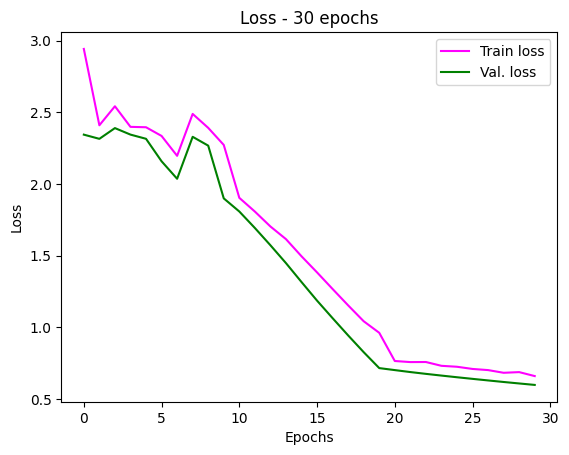

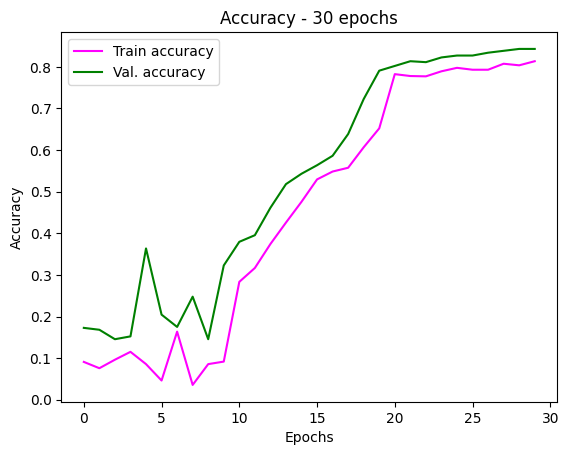

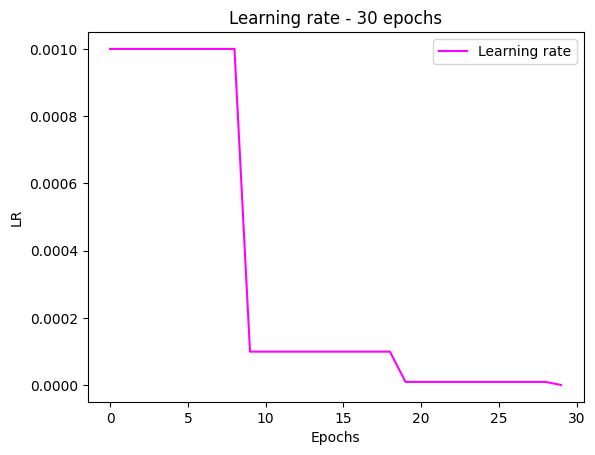

In [ ]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Plot - Loss
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf'))

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train accuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'acc_history.pdf'))

# Plot - LR
plt.figure()
plt.title(f'Learning rate - {epochs} epochs')
plt.plot(epochs_list, lr_list, c='magenta' ,ls='-', label='Learning rate', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf'))

**Avaliando o modelo sobre o set de validação**

In [ ]:
# Lista com as classes reais e classes preditas
true_test_list = []
pred_test_list = []
# Lista com as probabilidades
prob_test_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, label_list) in enumerate(test_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        labelList = label_list.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)

    prob_test_batch = list(outputs_prob.cpu())

    # Classes reais (true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_test_batch = list(label_list.cpu())
        pred_test_batch = list(preds.cpu())
    else:
        true_test_batch = list(label_list)
        pred_test_batch = list(preds)


    # Append batch results to the lists
    true_test_list += true_test_batch
    pred_test_list += pred_test_batch

    prob_test_list += prob_test_batch

**matriz de confusão e relatorio de classificação**

In [ ]:
# Confusion matrix
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
print('\nConfusion matrix ( test set)')
print(conf_mat_test)

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list, pred_test_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (test set)')
print(class_rep_test)

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_test))


Confusion matrix ( test set)
[[38  0  0  0  2  0  0  0  0  0  0]
 [ 0 39  0  1  0  0  0  0  0  0  0]
 [ 0  1 35  0  0  0  2  0  0  2  0]
 [ 0  6  0 26  2  4  0  2  0  0  0]
 [ 1  0  0  0 36  0  0  0  0  3  0]
 [ 0  0  0  0  0 40  0  0  0  0  0]
 [ 0  1  3  0  0  9 22  0  4  1  0]
 [ 0  0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0  0 40  0  0]
 [ 2  0  4  0  9  2  0  0  1 22  0]
 [ 0  0  0  0  0  0  0  1  0  0 39]]

Class. report (test set)
              precision    recall  f1-score   support

      Almond     0.9268    0.9500    0.9383        40
  Brazil Nut     0.8298    0.9750    0.8966        40
      Cashew     0.8333    0.8750    0.8537        40
    Chestnut     0.9630    0.6500    0.7761        40
    Hazelnut     0.7347    0.9000    0.8090        40
   Macadamia     0.7273    1.0000    0.8421        40
      Peanut     0.9167    0.5500    0.6875        40
       Pecan     0.9302    1.0000    0.9639        40
    Pine Nut     0.8889    1.0000    0.9412        40
   Pis

**Salvando o relatorio de classificação**

In [ ]:
class_rep_path = os.path.join(EXP_PATH, 'class_report_val.txt')
file_rep = open(class_rep_path, 'w')

file_rep.write('\nTEST. SET:')
file_rep.write('\n\nConfusion matrix:\n')
file_rep.write(str(conf_mat_test))
file_rep.write('\n\nClassification report:\n')
file_rep.write(class_rep_test)
file_rep.write('\n\nAccuracy:\t' + str(acc_test))

file_rep.close()

**Relatorio detalhado da classificação**

In [ ]:
# Conjunto de testes
class_rep_path = os.path.join(EXP_PATH, 'class_report_detailed_test.csv')
file_rep = open(class_rep_path, 'w')

print('\n#\tTarget\tPrediction\tCorrect?', end='')
file_rep.write('\n#;Target;Prediction;Correct?')

for class_name in class_names:
    print(f'\t {class_name}', end='')
    file_rep.write(f'\t {class_name}')

for i, (true, pred, probs) in enumerate(zip(true_test_list, pred_test_list, prob_test_list)):
    print(f'\n{i} \t {true} \t {pred} \t {true==pred}', end='')
    file_rep.write(f'\n{i};{true};{pred};{true==pred}')

    for prob in probs:
        print(f'\t{prob:.4f}', end='')
        file_rep.write(f';{prob:.4f}')

file_rep.close()